<a href="https://colab.research.google.com/github/jihwimin/FRED-RL/blob/main/FRED_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Imports**

In [ ]:
# Package installations
!pip install fredapi -q
!pip install yfinance -q
!pip install stable-baselines3[extra] -q
!pip install sb3-contrib -q

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import torch

# Data Collection APIs
from google.colab import userdata
from fredapi import Fred
import yfinance as yf

# Machine Learning & Preprocessing
from sklearn.preprocessing import StandardScaler

# Reinforcement Learning Algorithms
from stable_baselines3 import PPO, SAC, A2C, TD3
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.utils import set_random_seed

# API Keys
FRED_API_KEY = userdata.get('FRED_API_KEY')

# Random seed for reproducibility
SEED = 42
set_random_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 3.1 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# **Data Preprocessing**

In [ ]:
''' Fetching Economic Data from FRED '''

# FRED API Setup
fred = Fred(api_key=FRED_API_KEY)

# Economic Indicators - FRED Series IDs
indicators = {
    'Federal_Funds_Rate': 'FEDFUNDS',      # Federal Funds Rate (Leading indicator)
    'VIX': 'VIXCLS',                       # Volatility Index (Leading indicator)
    'GDP_Growth': 'A191RL1Q225SBEA',       # GDP Growth Rate, Quarterly (Coincident indicator)
    'Unemployment_Rate': 'UNRATE',         # Unemployment Rate (Lagging indicator)
    'Inflation_Rate': 'CPIAUCSL',          # Consumer Price Index (Lagging indicator)
    'Yield_10Y': 'DGS10',                  # 10-Year Treasury Yield
    'Yield_3M': 'DGS3MO',                  # 3-Month Treasury Yield (also used as Risk-Free Rate)
    'Consumer_Sentiment': 'UMCSENT'        # Consumer Sentiment Index
}

# Data collection period
start_date = '2004-01-01'
end_date = '2025-09-30'

# Step 1: Fetch data from FRED API
data_dict = {}
for name, series_id in indicators.items():
    data = fred.get_series(series_id, start_date=start_date, end_date=end_date)
    data = data[data.index >= start_date]
    data_dict[name] = data

# Combine all series into a single DataFrame
df = pd.DataFrame(data_dict)

# Step 2: Save Risk-Free Rate BEFORE dropping for Yield Spread
# 3-Month Treasury Bill is the standard proxy for risk-free rate
risk_free_rate = df['Yield_3M'].copy()

# Step 3: Feature Engineering - Yield Spread
if {'Yield_10Y', 'Yield_3M'}.issubset(df.columns):
    df['Yield_Spread_10Y_3M'] = df['Yield_10Y'] - df['Yield_3M']
    df = df.drop(columns=['Yield_10Y', 'Yield_3M'])

# Step 4: Convert CPI to Year-over-Year Inflation Rate (%)
if 'Inflation_Rate' in df.columns:
    df['Inflation_Rate'] = df['Inflation_Rate'].pct_change(periods=12) * 100

# Step 5: Handle missing values
df_filled = df.fillna(method='ffill')
df_filled = df_filled.fillna(method='bfill')

risk_free_rate = risk_free_rate.fillna(method='ffill')
risk_free_rate = risk_free_rate.fillna(method='bfill')

# Step 6: Temporal resampling - Convert to monthly frequency
df_monthly = df_filled.resample('MS').ffill()

# Risk-free rate: Convert from annual % to monthly decimal
# Annual rate 4% → Monthly rate 0.04/12 ≈ 0.0033
risk_free_monthly = risk_free_rate.resample('MS').ffill()
risk_free_monthly = risk_free_monthly / 100 / 12

# Step 7: Normalization - Z-score standardization (for economic indicators only)
scaler = StandardScaler()
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_monthly),
    index=df_monthly.index,
    columns=df_monthly.columns
)

# Step 8: Validation & export
print("Economic Indicators DataFrame")
print(f"Shape: {df_normalized.shape}")
print(f"Date range: {df_normalized.index.min()} to {df_normalized.index.max()}")
print(f"\nFirst 5 rows (normalized):")
print(df_normalized.head())

print(f"\nRisk-Free Rate (monthly decimal)")
print(f"Shape: {risk_free_monthly.shape}")
print(f"Sample values:")
print(risk_free_monthly.tail())

# Export to CSV
df_monthly.to_csv('fred_indicators_raw.csv')
df_normalized.to_csv('fred_indicators_normalized.csv')
risk_free_monthly.to_csv('risk_free_rate.csv')

Economic Indicators DataFrame
Shape: (264, 7)
Date range: 2004-01-01 00:00:00 to 2025-12-01 00:00:00

First 5 rows (normalized):
            Federal_Funds_Rate       VIX  GDP_Growth  Unemployment_Rate  \
2004-01-01           -0.407744 -0.098332    0.002356          -0.016528   
2004-02-01           -0.402559 -0.289423    0.002356          -0.065009   
2004-03-01           -0.407744 -0.552625    0.002356           0.031953   
2004-04-01           -0.407744 -0.287020    0.153150          -0.065009   
2004-05-01           -0.407744 -0.222121    0.153150          -0.065009   

            Inflation_Rate  Consumer_Sentiment  Yield_Spread_10Y_3M  
2004-01-01       -0.672082            1.774446             1.644435  
2004-02-01        0.012595            1.079586             1.485285  
2004-03-01        0.011128            1.183076             1.326135  
2004-04-01       -0.160770            1.064802             1.288242  
2004-05-01        0.689233            0.769117             1.720221  


/tmp/ipython-input-3333174755.py:43: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Inflation_Rate'] = df['Inflation_Rate'].pct_change(periods=12) * 100
/tmp/ipython-input-3333174755.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method='ffill')
/tmp/ipython-input-3333174755.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_filled.fillna(method='bfill')
/tmp/ipython-input-3333174755.py:49: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  risk_free_rate = risk_free_rate.fillna(m

In [ ]:
'''Fetching Asset Data from yfinance'''

import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler

assets = ['SPY', 'QQQ', 'TLT', 'GLD', 'VNQ']
start_date = '2004-01-01'
end_date = '2025-09-30'

def get_yfinance_data(symbols, start, end):
    """Fetch daily adjusted close prices using yfinance"""
    print(f"Fetching data for {len(symbols)} assets from Yahoo Finance...")

    data = yf.download(symbols, start=start, end=end, progress=False)

    # Use Adjusted Close (accounts for dividends and splits)
    # With auto_adjust=True (default), 'Close' is already adjusted.
    df = data['Close']

    if len(symbols) == 1:
        df = df.to_frame(name=symbols[0])

    return df

# Fetch data
df = get_yfinance_data(assets, start_date, end_date)

# Remove timezone immediately
df.index = pd.to_datetime(df.index).tz_localize(None)

print(f"\nRaw data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Missing values:\n{df.isnull().sum()}")

# Handle missing values
df_filled = df.ffill().bfill()

# Temporal resampling to monthly
df_monthly = df_filled.resample('MS').first()

print(f"\nMonthly data shape: {df_monthly.shape}")
print(f"Date range: {df_monthly.index.min()} to {df_monthly.index.max()}")
print(f"\nFirst 5 rows:")
print(df_monthly.head())
print(f"\nLast 5 rows:")
print(df_monthly.tail())

# Export RAW prices ONLY (no normalization!)
df_monthly.to_csv('asset_prices_raw.csv')

print("\n" + "=" * 60)
print("File Saved Successfully")
print("=" * 60)
print(f"- asset_prices_raw.csv: {df_monthly.shape}")
print("\nNote: Only raw prices saved. Normalization not needed for RL.")

/tmp/ipython-input-594172618.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start=start, end=end, progress=False)


Fetching data for 5 assets from Yahoo Finance...

Raw data shape: (5470, 5)
Date range: 2004-01-02 00:00:00 to 2025-09-29 00:00:00
Missing values:
Ticker
GLD    222
QQQ      0
SPY      0
TLT      0
VNQ    186
dtype: int64

Monthly data shape: (261, 5)
Date range: 2004-01-01 00:00:00 to 2025-09-01 00:00:00

First 5 rows:
Ticker            GLD        QQQ        SPY        TLT        VNQ
Date                                                             
2004-01-01  44.380001  30.762150  74.254303  41.031956  20.059347
2004-02-01  44.380001  31.278231  76.083496  42.206543  20.059347
2004-03-01  44.380001  31.345917  77.545464  43.243900  20.059347
2004-04-01  44.380001  30.592930  76.222878  43.727360  20.059347
2004-05-01  44.380001  29.696127  75.130936  41.187286  20.059347

Last 5 rows:
Ticker             GLD         QQQ         SPY        TLT        VNQ
Date                                                                
2025-05-01  297.459991  480.582520  555.284363  86.440147  86.92

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
'''Data Alignment'''

import pandas as pd

# Load data - economic is normalized, asset prices are RAW
economic_data = pd.read_csv('fred_indicators_normalized.csv', index_col=0, parse_dates=True)
asset_data = pd.read_csv('asset_prices_raw.csv', index_col=0, parse_dates=True)

# Ensure consistent datetime format
economic_data.index = pd.to_datetime(economic_data.index)
asset_data.index = pd.to_datetime(asset_data.index)

# Align timestamps
common_dates = economic_data.index.intersection(asset_data.index)
economic_data = economic_data.loc[common_dates]
asset_data = asset_data.loc[common_dates]

print(f"Common dates count: {len(common_dates)}")
print(f"Final data period: {common_dates[0]} ~ {common_dates[-1]}")

# Save aligned RAW prices
economic_data.to_csv('fred_indicators_aligned.csv')
asset_data.to_csv('asset_prices_aligned.csv')

print("\nFiles saved:")
print("- fred_indicators_aligned.csv (normalized economic data)")
print("- asset_prices_aligned.csv (RAW asset prices)")

Common dates count: 261
Final data period: 2004-01-01 00:00:00 ~ 2025-09-01 00:00:00

Files saved:
- fred_indicators_aligned.csv (normalized economic data)
- asset_prices_aligned.csv (RAW asset prices)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# **Custom RL Environment Implementation**

In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class PortfolioEnv(gym.Env):
    """
    Custom Gymnasium Environment for Portfolio Management using FRED Economic Indicators

    State Space: Economic indicators (normalized Z-scores)
    Action Space: Asset allocation weights (SPY, QQQ, TLT, GLD, VNQ)
    Reward Function: Configurable (Sharpe, Return, Hybrid, Benchmark-relative)
    """

    metadata = {'render_modes': ['human']}

    def __init__(self, economic_data, asset_prices, risk_free_rate, initial_balance=10000,
                 reward_method='hybrid', return_weight=0.7, benchmark_bonus=0.3):
        """
        Initialize portfolio management environment

        Args:
            economic_data (pd.DataFrame): Normalized economic indicators
            asset_prices (pd.DataFrame): Raw asset price data
            risk_free_rate (pd.Series): Monthly risk-free rate (decimal)
            initial_balance (float): Initial portfolio value
            reward_method (str): 'sharpe', 'return', 'hybrid', 'benchmark'
            return_weight (float): Weight for return in hybrid method (0-1)
            benchmark_bonus (float): Bonus multiplier for beating SPY
        """
        super().__init__()

        # Data
        self.economic_data = economic_data.values
        self.asset_prices = asset_prices.values
        self.risk_free_rate = risk_free_rate.values
        self.dates = economic_data.index

        # Configuration
        self.initial_balance = initial_balance
        self.n_assets = asset_prices.shape[1]
        self.n_indicators = economic_data.shape[1]
        self.max_steps = len(economic_data) - 1

        # Reward configuration
        self.reward_method = reward_method
        self.return_weight = return_weight
        self.sharpe_weight = 1 - return_weight
        self.benchmark_bonus = benchmark_bonus

        # Spaces
        self.observation_space = spaces.Box(
            low=-10.0, high=10.0,
            shape=(self.n_indicators,),
            dtype=np.float32
        )

        self.action_space = spaces.Box(
            low=0.0, high=1.0,
            shape=(self.n_assets,),
            dtype=np.float32
        )

        # State
        self.current_step = 0
        self.portfolio_value = initial_balance
        self.portfolio_history = []
        self.return_history = []

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)

        self.current_step = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_history = [self.initial_balance]
        self.return_history = []

        observation = self.economic_data[self.current_step].astype(np.float32)
        info = {
            'date': str(self.dates[self.current_step]),
            'portfolio_value': self.portfolio_value
        }

        return observation, info

    def step(self, action):
        """
        Execute one timestep (monthly rebalancing)

        Args:
            action (np.ndarray): Asset allocation weights

        Returns:
            observation, reward, terminated, truncated, info
        """
        # Normalize action weights to sum to 1.0
        action = np.clip(action, 0, 1)
        action = action / (np.sum(action) + 1e-8)

        # Get prices
        current_prices = self.asset_prices[self.current_step]
        next_prices = self.asset_prices[self.current_step + 1]

        # Calculate returns
        returns = (next_prices - current_prices) / (current_prices + 1e-8)
        portfolio_return = np.dot(action, returns)

        # Update portfolio
        self.portfolio_value *= (1 + portfolio_return)
        self.portfolio_history.append(self.portfolio_value)
        self.return_history.append(portfolio_return)

        # ====================================================================
        # Reward Calculation - Choose method
        # ====================================================================

        if self.reward_method == 'return':
            # Method 1: Pure return (maximize absolute profit)
            reward = portfolio_return

        elif self.reward_method == 'sharpe':
            # Method 2: Pure Sharpe ratio (risk-adjusted)
            reward = self._calculate_sharpe()

        elif self.reward_method == 'hybrid':
            # Method 3: Hybrid (balance return and risk)
            sharpe = self._calculate_sharpe()
            reward = self.return_weight * portfolio_return + self.sharpe_weight * sharpe

        elif self.reward_method == 'benchmark':
            # Method 4: Benchmark-relative (beat SPY)
            spy_return = returns[0]  # SPY is first asset
            reward = portfolio_return

            # Bonus for beating benchmark
            if portfolio_return > spy_return:
                reward += self.benchmark_bonus * (portfolio_return - spy_return)

        else:
            # Default: return
            reward = portfolio_return

        # Move to next timestep
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False

        # Next observation
        if not terminated:
            observation = self.economic_data[self.current_step].astype(np.float32)
        else:
            observation = np.zeros(self.n_indicators, dtype=np.float32)

        # Info
        info = {
            'date': str(self.dates[self.current_step]) if not terminated else 'END',
            'portfolio_value': self.portfolio_value,
            'portfolio_return': portfolio_return,
            'allocation': action.tolist(),
            'asset_returns': returns.tolist()
        }

        return observation, reward, terminated, truncated, info

    def _calculate_sharpe(self):
        """Calculate rolling Sharpe ratio"""
        if len(self.return_history) < 12:
            return 0.0

        recent_returns = np.array(self.return_history[-12:])
        start_idx = max(0, self.current_step - 11)
        end_idx = self.current_step + 1
        recent_rf = self.risk_free_rate[start_idx:end_idx]

        excess_returns = recent_returns - recent_rf
        mean_excess = np.mean(excess_returns)
        std_return = np.std(recent_returns) + 1e-8

        return mean_excess / std_return

    def render(self):
        """Visualize current environment state"""
        if self.current_step < len(self.dates):
            print(f"[{self.dates[self.current_step]}] Portfolio: ${self.portfolio_value:,.2f} | Step: {self.current_step}/{self.max_steps}")

In [ ]:
""" Environment Validation Test """

# Load preprocessed data
asset_prices_raw = pd.read_csv('asset_prices_raw.csv', index_col=0, parse_dates=True)
risk_free_rate = pd.read_csv('risk_free_rate.csv', index_col=0, parse_dates=True)
risk_free_rate = risk_free_rate.squeeze()  # Convert DataFrame to Series

# Align timestamps
asset_prices_raw = asset_prices_raw.loc[common_dates]
risk_free_rate = risk_free_rate.loc[common_dates]

# Initialize environment with risk-free rate
env = PortfolioEnv(
    economic_data=economic_data,
    asset_prices=asset_prices_raw,
    risk_free_rate=risk_free_rate,
    initial_balance=10000
)

print("Environment Test: Random actions for 10 steps")

obs, info = env.reset()
print(f"\nInitial observation (economic indicators): {obs}")
print(f"Initial date: {info['date']}")

for step in range(10):
    # Generate random allocation weights that sum to 1
    action = np.random.dirichlet(np.ones(5))

    obs, reward, terminated, truncated, info = env.step(action)

    print(f"\n--- Step {step + 1} ---")
    print(f"Date: {info['date']}")
    print(f"Allocation: {[f'{a:.1%}' for a in info['allocation']]}")
    print(f"Portfolio return: {info['portfolio_return']:.2%}")
    print(f"Reward: {reward:.4f}")
    print(f"Portfolio value: ${info['portfolio_value']:,.2f}")

    if terminated:
        print("\nEpisode terminated")
        break

Environment Test: Random actions for 10 steps

Initial observation (economic indicators): [-0.4077444  -0.09833177  0.00235616 -0.01652759 -0.67208153  1.7744462
  1.6444353 ]
Initial date: 2004-01-01 00:00:00

--- Step 1 ---
Date: 2004-02-01 00:00:00
Allocation: ['8.0%', '51.2%', '22.4%', '15.5%', '2.9%']
Portfolio return: 1.86%
Reward: 0.0130
Portfolio value: $10,185.53

--- Step 2 ---
Date: 2004-03-01 00:00:00
Allocation: ['3.9%', '1.4%', '45.8%', '20.9%', '28.0%']
Portfolio return: 1.40%
Reward: 0.0098
Portfolio value: $10,327.88

--- Step 3 ---
Date: 2004-04-01 00:00:00
Allocation: ['0.4%', '60.9%', '31.1%', '4.2%', '3.5%']
Portfolio return: -1.95%
Reward: -0.0136
Portfolio value: $10,126.78

--- Step 4 ---
Date: 2004-05-01 00:00:00
Allocation: ['9.1%', '16.3%', '33.5%', '25.5%', '15.5%']
Portfolio return: -2.44%
Reward: -0.0171
Portfolio value: $9,879.70

--- Step 5 ---
Date: 2004-06-01 00:00:00
Allocation: ['37.7%', '6.0%', '13.8%', '18.2%', '24.3%']
Portfolio return: 0.07%
Rewa

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# **Training & Evaluation**

In [ ]:
# Load Data - Use RAW prices, not normalized

# Load preprocessed data
economic_data = pd.read_csv('fred_indicators_normalized.csv', index_col=0, parse_dates=True)
asset_prices_raw = pd.read_csv('asset_prices_raw.csv', index_col=0, parse_dates=True)
risk_free_rate = pd.read_csv('risk_free_rate.csv', index_col=0, parse_dates=True).squeeze()

# Align timestamps - keep only dates present in all datasets
common_dates = economic_data.index.intersection(asset_prices_raw.index).intersection(risk_free_rate.index)
economic_data = economic_data.loc[common_dates]
asset_prices_raw = asset_prices_raw.loc[common_dates]
risk_free_rate = risk_free_rate.loc[common_dates]

print(f"Common dates count: {len(common_dates)}")
print(f"Data period: {common_dates[0]} ~ {common_dates[-1]}")

# Train/Test split (80/20)
split_idx = int(len(economic_data) * 0.8)

train_economic = economic_data.iloc[:split_idx]
train_prices = asset_prices_raw.iloc[:split_idx]  # RAW prices
train_rf = risk_free_rate.iloc[:split_idx]

test_economic = economic_data.iloc[split_idx:]
test_prices = asset_prices_raw.iloc[split_idx:]  # RAW prices
test_rf = risk_free_rate.iloc[split_idx:]

# Create environments
train_env = PortfolioEnv(
    economic_data=train_economic,
    asset_prices=train_prices,
    risk_free_rate=train_rf,
    initial_balance=10000
)
train_env = Monitor(train_env)
train_env.reset(seed=SEED)

test_env = PortfolioEnv(
    economic_data=test_economic,
    asset_prices=test_prices,
    risk_free_rate=test_rf,
    initial_balance=10000
)

n_months_train = len(train_economic)
n_actions = train_env.action_space.shape[-1]

print(f"\nTrain: {train_economic.index[0]} ~ {train_economic.index[-1]} ({n_months_train} months)")
print(f"Test: {test_economic.index[0]} ~ {test_economic.index[-1]} ({len(test_economic)} months)")

Common dates count: 261
Data period: 2004-01-01 00:00:00 ~ 2025-09-01 00:00:00

Train: 2004-01-01 00:00:00 ~ 2021-04-01 00:00:00 (208 months)
Test: 2021-05-01 00:00:00 ~ 2025-09-01 00:00:00 (53 months)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Configuration
Episodes: 40 | LR: 0.0001 | Gamma: 0.8
Reward: benchmark | Seed: 42

Train: 2004-01-01 00:00:00 ~ 2021-04-01 00:00:00 (208 months)
Test: 2021-05-01 00:00:00 ~ 2025-09-01 00:00:00 (53 months)

Training models...

[1/5] Training PPO...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


  Completed in 8.4s

[2/5] Training SAC...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Completed in 117.8s

[3/5] Training A2C...
  Completed in 6.3s

[4/5] Training TD3...
  Completed in 98.1s

[5/5] Training RecurrentPPO...
  Completed in 245.9s

Evaluating models on test set...

Performance Summary
Model            Return   Sharpe   Max DD     Time
----------------------------------------------------------
PPO             44.37%    0.704 -17.52%     8.4s
SAC             37.04%    0.612 -23.34%   117.8s
A2C             54.63%    0.850 -19.03%     6.3s
TD3             69.42%    0.861 -25.35%    98.1s
RPPO            70.73%    0.749 -30.47%   245.9s
SPY             94.02%    1.180      N/A      N/A
----------------------------------------------------------

Best Return: RPPO (+70.73%)
Best Sharpe: TD3 (0.861)
Underperformed SPY by 23.30%

Generating visualizations...


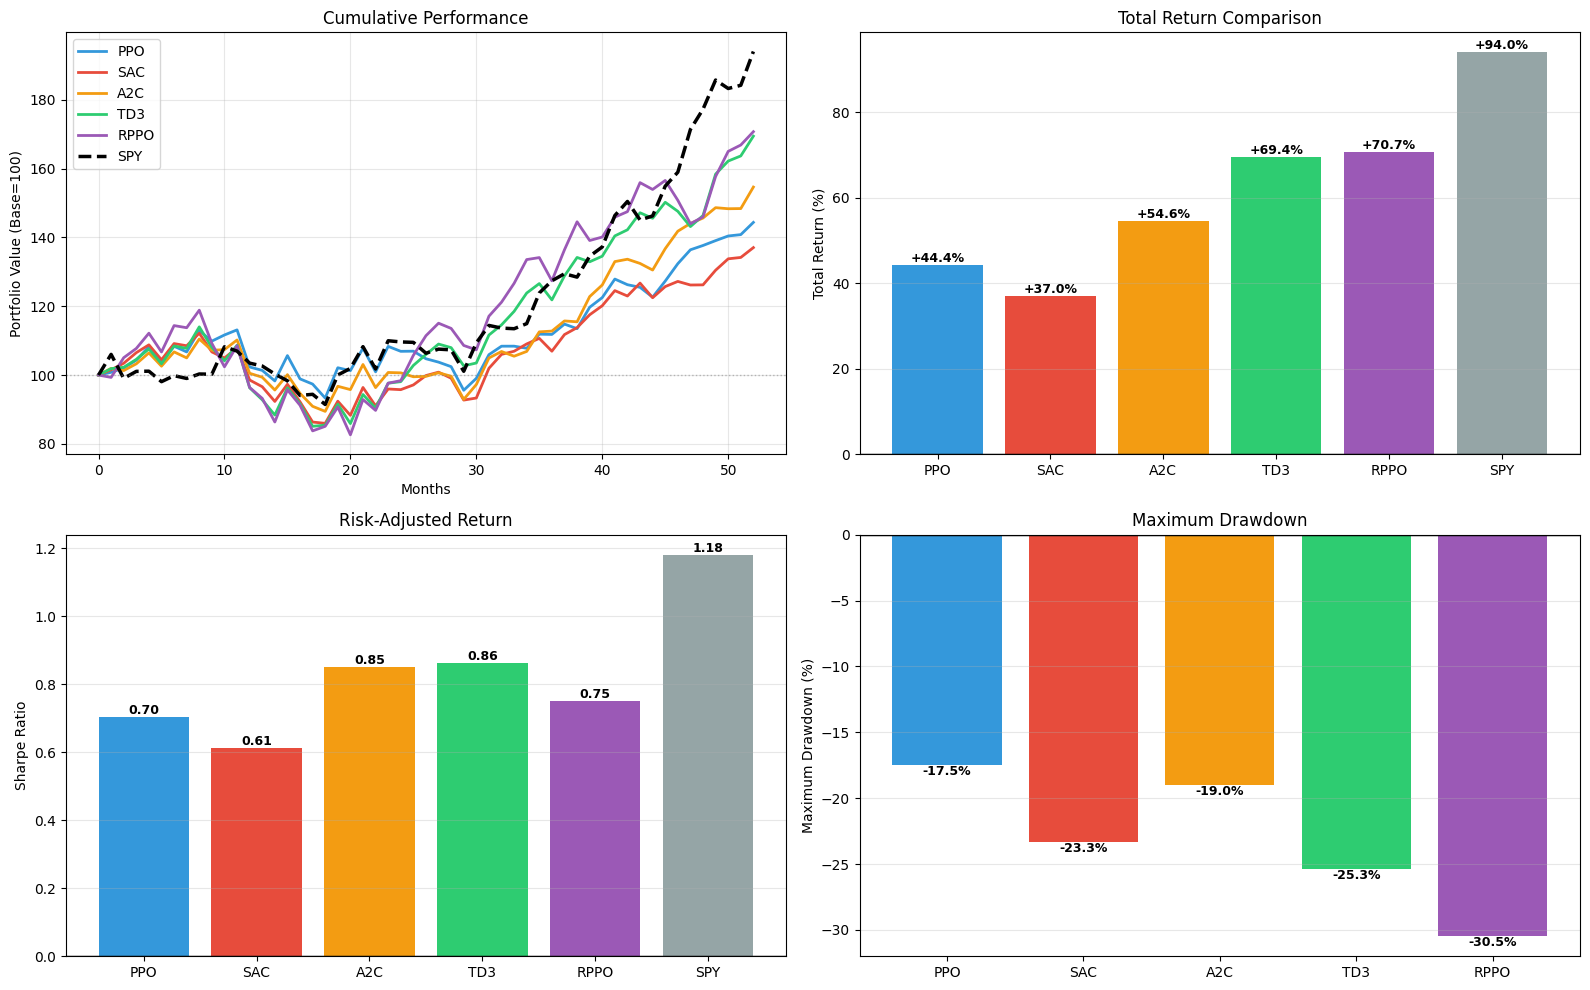

Saved: ./model_comparison.png

Comparison completed.


In [ ]:
# Hyperparameter Configuration

# Training parameters (adjust here for experiments)
N_EPISODES = 40
LEARNING_RATE = 1e-4
GAMMA = 0.80
SEED = 42

# Reward function settings
REWARD_METHOD = 'benchmark'        # Options: 'sharpe', 'return', 'hybrid', 'benchmark'
RETURN_WEIGHT = 0.8             # For hybrid: weight for absolute return (0-1)
BENCHMARK_BONUS = 0.5           # For benchmark: bonus for beating SPY

print("Configuration")
print(f"Episodes: {N_EPISODES} | LR: {LEARNING_RATE} | Gamma: {GAMMA}")
print(f"Reward: {REWARD_METHOD} | Seed: {SEED}\n")

# Setup Environments

train_env = PortfolioEnv(
    economic_data=train_economic,
    asset_prices=train_prices,
    risk_free_rate=train_rf,
    initial_balance=10000,
    reward_method=REWARD_METHOD,
    return_weight=RETURN_WEIGHT,
    benchmark_bonus=BENCHMARK_BONUS
)

test_env = PortfolioEnv(
    economic_data=test_economic,
    asset_prices=test_prices,
    risk_free_rate=test_rf,
    initial_balance=10000,
    reward_method=REWARD_METHOD,
    return_weight=RETURN_WEIGHT,
    benchmark_bonus=BENCHMARK_BONUS
)

train_env = Monitor(train_env)
train_env.reset(seed=SEED)

n_months_train = len(train_economic)
n_actions = train_env.action_space.shape[-1]

print(f"Train: {train_economic.index[0]} ~ {train_economic.index[-1]} ({n_months_train} months)")
print(f"Test: {test_economic.index[0]} ~ {test_economic.index[-1]} ({len(test_economic)} months)\n")

# ============================================================================
# Helper Functions
# ============================================================================

def test_model(model, test_env, model_name, seed=SEED, is_recurrent=False):
    """Evaluate model on test set"""
    obs, info = test_env.reset(seed=seed)
    portfolio_values = [info['portfolio_value']]

    if is_recurrent:
        lstm_states = None
        episode_start = True

    while True:
        if is_recurrent:
            action, lstm_states = model.predict(
                obs, state=lstm_states, episode_start=episode_start, deterministic=True
            )
            episode_start = False
        else:
            action, _ = model.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = test_env.step(action)
        portfolio_values.append(info['portfolio_value'])

        if terminated:
            break

    # Calculate metrics
    portfolio_values = np.array(portfolio_values)
    total_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]

    monthly_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe = (np.mean(monthly_returns) * 12) / (np.std(monthly_returns) * np.sqrt(12)) \
             if np.std(monthly_returns) > 0 else 0

    running_max = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - running_max) / running_max
    max_drawdown = np.min(drawdown)

    return {
        'name': model_name,
        'portfolio_values': portfolio_values,
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown
    }

# ============================================================================
# Train Models
# ============================================================================

print("Training models...\n")

# PPO
print(f"[1/5] Training PPO...")
ppo_model = PPO(
    policy="MlpPolicy", env=train_env, learning_rate=LEARNING_RATE,
    n_steps=n_months_train-1, batch_size=n_months_train-1,
    n_epochs=10, gamma=GAMMA, gae_lambda=0.95, clip_range=0.2,
    verbose=0, device='cpu', seed=SEED
)
start = time.time()
for i in range(N_EPISODES):
    ppo_model.learn(total_timesteps=n_months_train-1, reset_num_timesteps=(i==0), progress_bar=False)
ppo_time = time.time() - start
ppo_model.save("./models/ppo_comparison")
print(f"  Completed in {ppo_time:.1f}s\n")

# SAC
print(f"[2/5] Training SAC...")
sac_model = SAC(
    policy="MlpPolicy", env=train_env, learning_rate=LEARNING_RATE,
    buffer_size=10000, learning_starts=n_months_train, batch_size=64,
    tau=0.005, gamma=GAMMA, train_freq=1, gradient_steps=1, ent_coef='auto',
    verbose=0, device='cpu', seed=SEED
)
start = time.time()
sac_model.learn(total_timesteps=(n_months_train-1)*N_EPISODES, progress_bar=False)
sac_time = time.time() - start
sac_model.save("./models/sac_comparison")
print(f"  Completed in {sac_time:.1f}s\n")

# A2C
print(f"[3/5] Training A2C...")
a2c_model = A2C(
    policy="MlpPolicy", env=train_env, learning_rate=LEARNING_RATE,
    n_steps=n_months_train-1, gamma=GAMMA, gae_lambda=1.0,
    ent_coef=0.01, vf_coef=0.5, max_grad_norm=0.5,
    verbose=0, device='cpu', seed=SEED
)
start = time.time()
for i in range(N_EPISODES):
    a2c_model.learn(total_timesteps=n_months_train-1, reset_num_timesteps=(i==0), progress_bar=False)
a2c_time = time.time() - start
a2c_model.save("./models/a2c_comparison")
print(f"  Completed in {a2c_time:.1f}s\n")

# TD3
print(f"[4/5] Training TD3...")
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1*np.ones(n_actions))
td3_model = TD3(
    policy="MlpPolicy", env=train_env, learning_rate=LEARNING_RATE,
    buffer_size=10000, learning_starts=100, batch_size=64,
    tau=0.005, gamma=GAMMA, train_freq=(1, "step"), gradient_steps=1,
    action_noise=action_noise, verbose=0, device="cpu", seed=SEED
)
start = time.time()
td3_model.learn(total_timesteps=(n_months_train-1)*N_EPISODES, progress_bar=False)
td3_time = time.time() - start
td3_model.save("./models/td3_comparison")
print(f"  Completed in {td3_time:.1f}s\n")

# RecurrentPPO
print(f"[5/5] Training RecurrentPPO...")
rppo_model = RecurrentPPO(
    policy="MlpLstmPolicy", env=train_env, learning_rate=LEARNING_RATE,
    n_steps=n_months_train-1, batch_size=n_months_train-1,
    n_epochs=10, gamma=GAMMA, gae_lambda=0.95, clip_range=0.2,
    verbose=0, device='cpu', seed=SEED
)
start = time.time()
for i in range(N_EPISODES):
    rppo_model.learn(total_timesteps=n_months_train-1, reset_num_timesteps=(i==0), progress_bar=False)
rppo_time = time.time() - start
rppo_model.save("./models/rppo_comparison")
print(f"  Completed in {rppo_time:.1f}s\n")

# ============================================================================
# Evaluate Models
# ============================================================================

print("Evaluating models on test set...\n")

ppo_results = test_model(ppo_model, test_env, "PPO")
sac_results = test_model(sac_model, test_env, "SAC")
a2c_results = test_model(a2c_model, test_env, "A2C")
td3_results = test_model(td3_model, test_env, "TD3")
rppo_results = test_model(rppo_model, test_env, "RPPO", is_recurrent=True)

results_list = [ppo_results, sac_results, a2c_results, td3_results, rppo_results]
times = [ppo_time, sac_time, a2c_time, td3_time, rppo_time]

# SPY benchmark
test_prices_spy = asset_prices_raw.iloc[split_idx:]
spy_return = (test_prices_spy.iloc[-1, 0] - test_prices_spy.iloc[0, 0]) / test_prices_spy.iloc[0, 0]
spy_monthly = test_prices_spy.iloc[:, 0].pct_change().dropna()
spy_sharpe = (spy_monthly.mean() * 12) / (spy_monthly.std() * np.sqrt(12))

# ============================================================================
# Results Summary
# ============================================================================

print("Performance Summary")
print(f"{'Model':<12} {'Return':>10} {'Sharpe':>8} {'Max DD':>8} {'Time':>8}")
print("-" * 58)

for res, t in zip(results_list, times):
    print(f"{res['name']:<12} {res['total_return']:>9.2%} {res['sharpe']:>8.3f} "
          f"{res['max_drawdown']:>7.2%} {t:>7.1f}s")

print(f"{'SPY':<12} {spy_return:>9.2%} {spy_sharpe:>8.3f} {'N/A':>8} {'N/A':>8}")
print("-" * 58)

best_return = max(results_list, key=lambda x: x['total_return'])
best_sharpe = max(results_list, key=lambda x: x['sharpe'])

print(f"\nBest Return: {best_return['name']} ({best_return['total_return']:+.2%})")
print(f"Best Sharpe: {best_sharpe['name']} ({best_sharpe['sharpe']:.3f})")

gap = (best_return['total_return'] - spy_return) * 100
status = "Outperformed" if gap > 0 else "Underperformed"
print(f"{status} SPY by {abs(gap):.2f}%\n")

# ============================================================================
# Visualization
# ============================================================================

print("Generating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71', '#9b59b6', '#95a5a6']

# Portfolio value over time
ax1 = axes[0, 0]
for i, res in enumerate(results_list):
    normalized = res['portfolio_values'] / res['portfolio_values'][0] * 100
    ax1.plot(normalized, label=res['name'], linewidth=2, color=colors[i])

spy_prices = test_prices_spy.iloc[:, 0].values
spy_normalized = spy_prices / spy_prices[0] * 100
ax1.plot(spy_normalized, label='SPY', linewidth=2.5, linestyle='--', color='black')

ax1.axhline(y=100, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_xlabel('Months')
ax1.set_ylabel('Portfolio Value (Base=100)')
ax1.set_title('Cumulative Performance')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Total return
ax2 = axes[0, 1]
names = [r['name'] for r in results_list] + ['SPY']
returns = [r['total_return'] * 100 for r in results_list] + [spy_return * 100]
bars = ax2.bar(names, returns, color=colors)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.set_ylabel('Total Return (%)')
ax2.set_title('Total Return Comparison')
ax2.grid(True, alpha=0.3, axis='y')

for bar, ret in zip(bars, returns):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height,
            f'{ret:+.1f}%', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

# Sharpe ratio
ax3 = axes[1, 0]
sharpes = [r['sharpe'] for r in results_list] + [spy_sharpe]
bars = ax3.bar(names, sharpes, color=colors)
ax3.axhline(y=0, color='black', linewidth=1)
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Risk-Adjusted Return')
ax3.grid(True, alpha=0.3, axis='y')

for bar, sharpe in zip(bars, sharpes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height,
            f'{sharpe:.2f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

# Maximum drawdown
ax4 = axes[1, 1]
dd_names = [r['name'] for r in results_list]
drawdowns = [r['max_drawdown'] * 100 for r in results_list]
bars = ax4.bar(dd_names, drawdowns, color=colors[:-1])
ax4.axhline(y=0, color='black', linewidth=1)
ax4.set_ylabel('Maximum Drawdown (%)')
ax4.set_title('Maximum Drawdown')
ax4.grid(True, alpha=0.3, axis='y')

for bar, dd in zip(bars, drawdowns):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height,
            f'{dd:.1f}%', ha='center', va='top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('./model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: ./model_comparison.png")
print("\nComparison completed.")

# **Visualization**




TD3 yearly average weights:
           GLD       QQQ       SPY       TLT       VNQ
Year                                                  
2021  0.713096  0.743934  0.791804  0.017142  0.006021
2022  0.153132  0.718055  0.094751  0.153382  0.000013
2023  0.505803  0.823061  0.551261  0.000034  0.000013
2024  0.382215  0.807452  0.748900  0.000370  0.000301
2025  0.402192  0.701751  0.117715  0.001952  0.001246


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


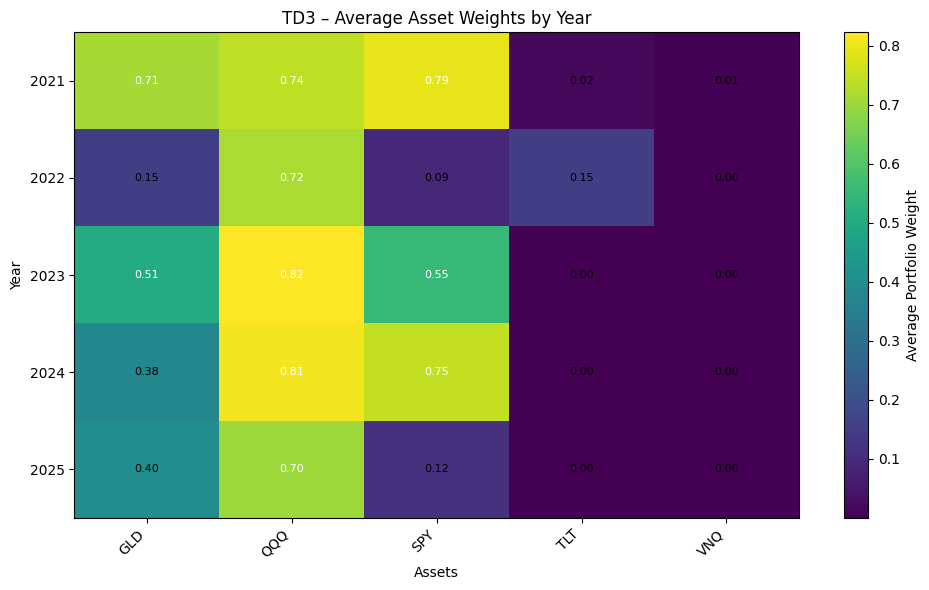

Saved: ./td3_yearly_weights_heatmap.png
Treemap skipped (install 'squarify' to enable).


In [ ]:
# ============================================================================
# TD3 Asset Allocation Visualization (Heatmap + Treemap)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: treemap library (pip install squarify)
try:
    import squarify
    HAS_SQUARIFY = True
except ImportError:
    HAS_SQUARIFY = False
    print("Warning: 'squarify' not installed. Treemap will be skipped.")


def get_allocation_history(model, env, asset_names, dates_index, seed=SEED, is_recurrent=False):
    """
    Run a model on the given env and record portfolio weights (actions) over time.

    Parameters
    ----------
    model : SB3 model
        Trained model (TD3 here).
    env : gym-like environment
        PortfolioEnv wrapped in Monitor (same as test_env).
    asset_names : list[str]
        Column names of assets.
    dates_index : pandas.DatetimeIndex
        Index of dates for the test period. Length should be >= number of steps.
    seed : int
        Seed for env.reset
    is_recurrent : bool
        Whether model is recurrent (not needed for TD3).

    Returns
    -------
    alloc_df : pd.DataFrame
        Index: dates, Columns: asset_names, Values: weights per asset.
    """
    obs, info = env.reset(seed=seed)
    weights_history = []
    step_dates = []

    if is_recurrent:
        lstm_states = None
        episode_start = True

    step_idx = 0

    while True:
        if is_recurrent:
            action, lstm_states = model.predict(
                obs, state=lstm_states, episode_start=episode_start, deterministic=True
            )
            episode_start = False
        else:
            action, _ = model.predict(obs, deterministic=True)

        # assume action is the weight vector
        action = np.array(action).reshape(-1)

        obs, reward, terminated, truncated, info = env.step(action)

        weights_history.append(action)
        # align step index with test dates
        if step_idx < len(dates_index):
            step_dates.append(dates_index[step_idx])
        else:
            # safety: just repeat last date if something is off
            step_dates.append(dates_index[-1])

        step_idx += 1

        if terminated:
            break

    weights_history = np.vstack(weights_history)

    alloc_df = pd.DataFrame(
        weights_history,
        index=pd.DatetimeIndex(step_dates),
        columns=asset_names
    )

    return alloc_df


# 1) Get asset names & dates for test period
asset_names = test_prices.columns.tolist()          # same assets as env
test_dates = test_economic.index                   # monthly dates for test period

# 2) Run TD3 on test_env and capture allocations
print("\nCollecting TD3 allocation history on test set...")
td3_alloc_df = get_allocation_history(
    td3_model, test_env, asset_names, test_dates, seed=SEED, is_recurrent=False
)

# 3) Aggregate to yearly averages
td3_alloc_df['Year'] = td3_alloc_df.index.year
yearly_alloc = td3_alloc_df.groupby('Year')[asset_names].mean()

print("\nTD3 yearly average weights:")
print(yearly_alloc)

# ============================================================================
# Heatmap: TD3 average asset weights by year
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(yearly_alloc.values, aspect='auto')

# Axis ticks
ax.set_xticks(range(len(asset_names)))
ax.set_xticklabels(asset_names, rotation=45, ha='right')
ax.set_yticks(range(len(yearly_alloc.index)))
ax.set_yticklabels(yearly_alloc.index)

# Add value annotations
for i in range(yearly_alloc.shape[0]):
    for j in range(yearly_alloc.shape[1]):
        value = yearly_alloc.values[i, j]
        ax.text(
            j, i, f"{value:.2f}",
            ha='center', va='center',
            fontsize=8,
            color='white' if value > 0.5 else 'black'
        )

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Average Portfolio Weight')

ax.set_title('TD3 – Average Asset Weights by Year')
ax.set_xlabel('Assets')
ax.set_ylabel('Year')

plt.tight_layout()
plt.savefig('./td3_yearly_weights_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: ./td3_yearly_weights_heatmap.png")

# ============================================================================
# Treemap: TD3 allocation for the most recent year
# ============================================================================

if HAS_SQUARIFY:
    latest_year = yearly_alloc.index[-1]
    latest_weights = yearly_alloc.loc[latest_year].values
    latest_labels = [
        f"{name}\n{w:.1%}" for name, w in zip(asset_names, latest_weights)
    ]

    fig, ax = plt.subplots(figsize=(8, 6))
    squarify.plot(
        sizes=latest_weights,
        label=latest_labels,
        ax=ax,
        pad=True
    )
    ax.set_title(f"TD3 Asset Allocation Treemap – {latest_year}")
    ax.axis('off')

    plt.tight_layout()
    plt.savefig('./td3_latest_year_treemap.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved: ./td3_latest_year_treemap.png")
else:
    print("Treemap skipped (install 'squarify' to enable).")


In [ ]:
import numpy as np
import pandas as pd

# ----------------------------
# TD3가 테스트 구간에서 선택한 월별 비중 기록
# ----------------------------
def get_td3_allocation_history(model, env, asset_names, dates_index, seed=SEED):
    obs, info = env.reset(seed=seed)
    weights_history = []
    step_dates = []
    step_idx = 0

    while True:
        action, _ = model.predict(obs, deterministic=True)
        action = np.array(action).reshape(-1)

        obs, reward, terminated, truncated, info = env.step(action)

        weights_history.append(action)

        # 월 단위 날짜 인덱스와 맞추기
        if step_idx < len(dates_index):
            step_dates.append(dates_index[step_idx])
        else:
            step_dates.append(dates_index[-1])

        step_idx += 1
        if terminated:
            break

    weights_history = np.vstack(weights_history)

    alloc_df = pd.DataFrame(
        weights_history,
        index=pd.DatetimeIndex(step_dates),
        columns=asset_names
    )
    return alloc_df


asset_names = test_prices.columns.tolist()
test_dates = test_economic.index

td3_alloc_df = get_td3_allocation_history(
    td3_model, test_env, asset_names, test_dates, seed=SEED
)

# 연도 컬럼 추가
td3_alloc_df["Year"] = td3_alloc_df.index.year

# 연도별 평균 비중 (그냥 평균)
yearly_alloc = td3_alloc_df.groupby("Year")[asset_names].mean()

# ★ 연도별로 합이 1이 되도록 정규화 (레버리지/캐시 허용되더라도, 설명용으로는 이렇게 보는 게 편함)
yearly_alloc_norm = yearly_alloc.div(yearly_alloc.sum(axis=1), axis=0)

print("연도별 평균 비중 (정규화 후, 합=1):")
print(yearly_alloc_norm.round(3))


연도별 평균 비중 (정규화 후, 합=1):
        GLD    QQQ    SPY    TLT    VNQ
Year                                   
2021  0.314  0.327  0.349  0.008  0.003
2022  0.137  0.642  0.085  0.137  0.000
2023  0.269  0.438  0.293  0.000  0.000
2024  0.197  0.416  0.386  0.000  0.000
2025  0.328  0.573  0.096  0.002  0.001


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import matplotlib.pyplot as plt
import squarify

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = '#FFFFFF'
plt.rcParams['figure.facecolor'] = '#FFFFFF'

color_map = {
    "equity": "#4CAF50",
    "bond":   "#2196F3",
    "gold":   "#F1C40F",
    "other":  "#9E9E9E"
}

equity_assets = {"SPY", "QQQ", "VOO"}
bond_assets   = {"IEF", "BND", "TLT"}
gold_assets   = {"GLD", "IAU", "Gold"}

def get_color(asset):
    if asset in gold_assets:
        return color_map["gold"]
    elif asset in bond_assets:
        return color_map["bond"]
    elif asset in equity_assets:
        return color_map["equity"]
    else:
        return color_map["other"]

def plot_td3_treemap_for_year_pretty(year):
    if year not in yearly_alloc_norm.index:
        raise ValueError(f"{year}년 데이터가 없습니다.")

    weights = yearly_alloc_norm.loc[year]
    weights = weights[weights > 1e-4]

    sizes = weights.values
    labels = [f"{asset}\n{w:.1%}" for asset, w in weights.items()]
    colors = [get_color(asset) for asset in weights.index]

    fig, ax = plt.subplots(figsize=(8, 6))

    squarify.plot(
        sizes=sizes,
        label=labels,
        color=colors,
        pad=True,
        ax=ax,
        text_kwargs={
            "color": "white",
            "fontsize": 13,
            "fontweight": "bold"
            # ha / va는 넣지 않음!!! (squarify 내부에서 자동 설정)
        }
    )

    ax.set_title(
        f"TD3 Portfolio Asset Allocation Treemap – {year} Average",
        fontsize=16,
        fontweight="bold",
        pad=20
    )

    ax.axis("off")
    plt.tight_layout()
    plt.show()


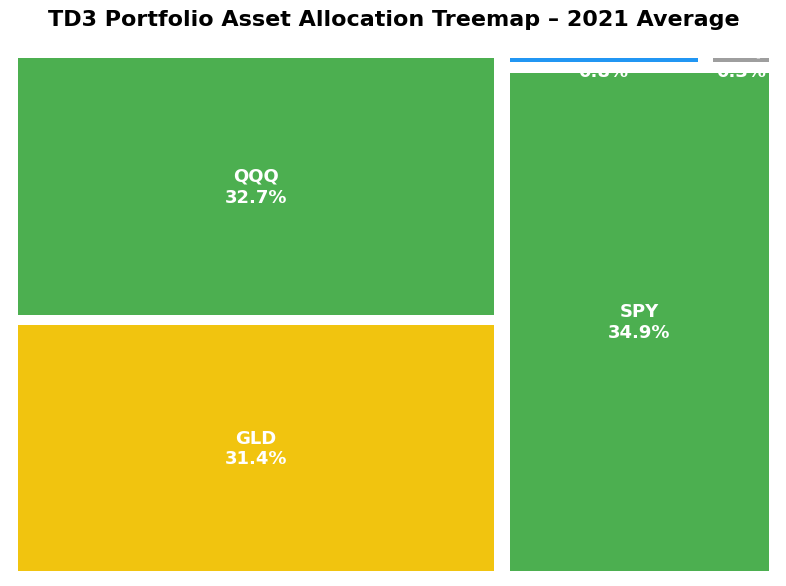

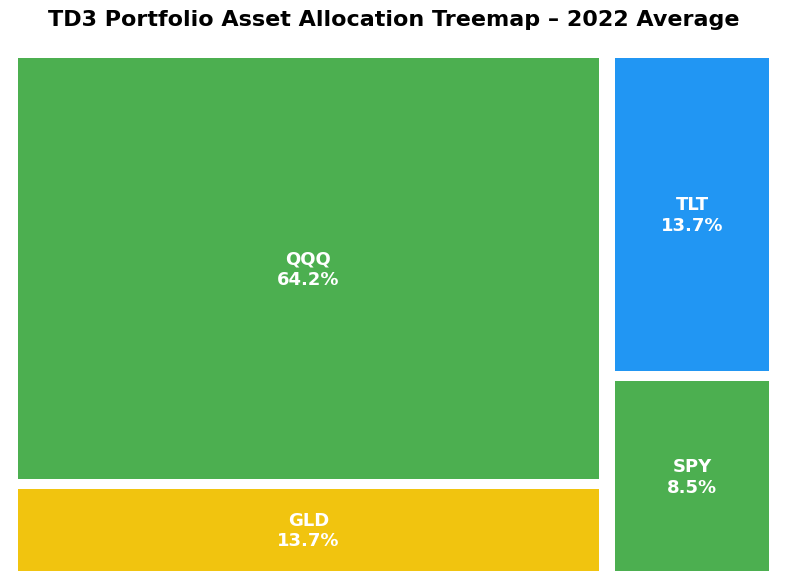

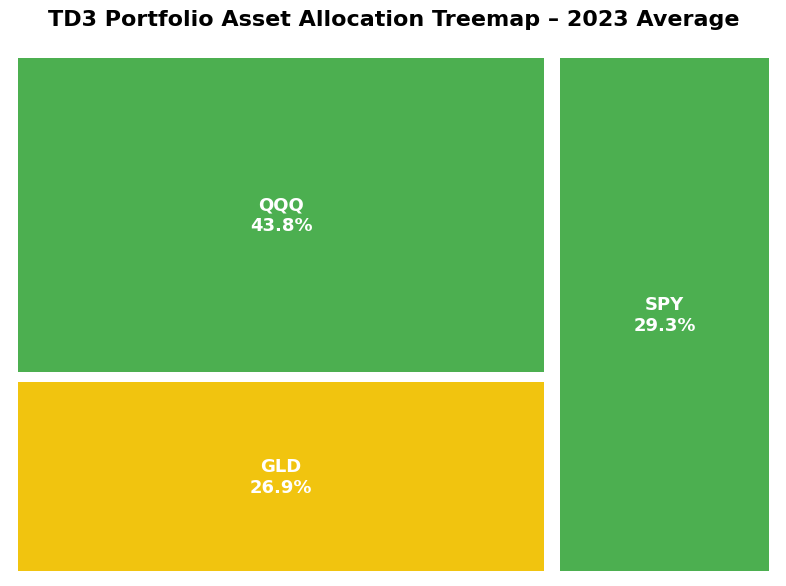

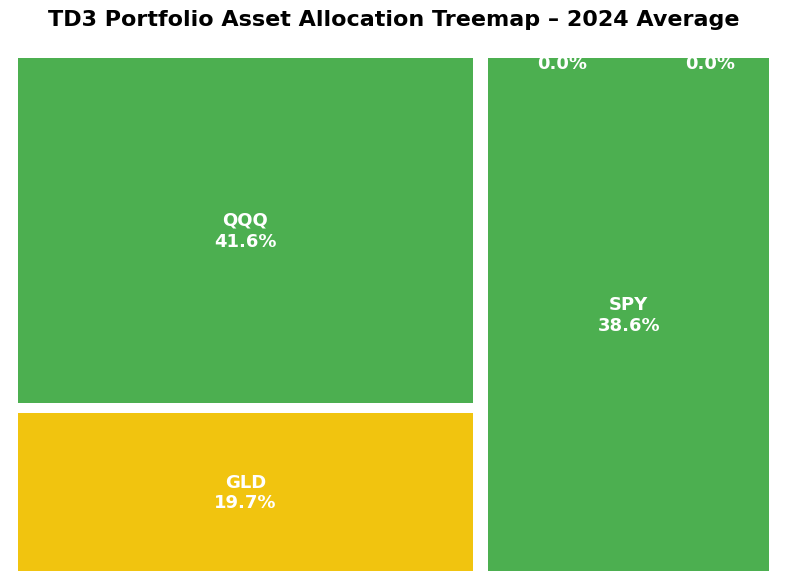

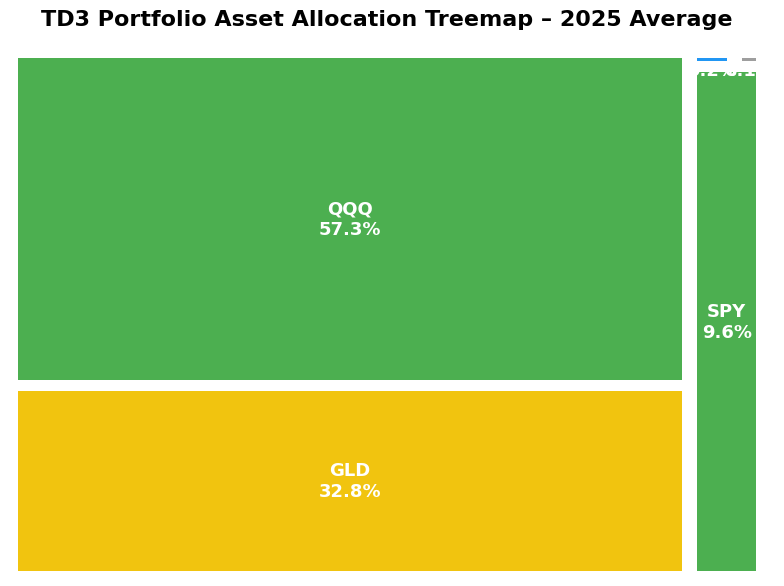

In [ ]:
for y in yearly_alloc_norm.index:
    plot_td3_treemap_for_year_pretty(y)
